# Augur for Influenza A - HA protein

## Import packages

In [3]:
from Bio import Phylo
import matplotlib
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import pandas as pd

## Configuration variables

In [33]:
subsample = 5
print("test for %s" %subsample)

test for 5


## Metadata is required -- Piece metadata file together

In [6]:
## Metadata is required

# Making metadata by parsing FASTA


records = []
for record in SeqIO.parse("../data/fluHA_sequences-with-metadata.fasta", "fasta"):
    records.append(record.description)

    
# Split description
split = []
for record in records:
    split.append(record.split('|'))

# Grab metadata from split description    
strainsList = []
idList = []
dateUnsplit = []
countryList = []
stateList = []
for item in split:
    strainsList.append(item[0])
    idList.append(item[1])
    dateUnsplit.append(item[2])
    countryList.append(item[3])
    stateList.append(item[4])

### Get dates from fasta.description

In [17]:
# Get dates
dateSearch = re.compile('(?P<month>\d{2})[/](?P<day>\d{2})[/](?P<year>\d{4}$)')
yearSearch = re.compile('(?P<year>\d{4}$)')
monthYearSearch = re.compile('(?P<month>\d{2})[/](?P<year>\d{4}$)')
monthList = []
dayList = []
yearList = []
for item in dateUnsplit:
    if len(item) == 4:
        y = yearSearch.search(item)
        year = y.group('year')
        yearList.append(year)
        monthList.append('XX')
        dayList.append('XX')
    elif len(item) == 10:
        d = dateSearch.search(item)
        month = d.group('month')
        day = d.group('day')
        year = d.group('year')
    
        monthList.append(month)
        dayList.append(day)
        yearList.append(year)
    elif len(item) == 7:
        d = monthYearSearch.search(item)
        month = d.group('month')
        year = d.group('year')
    
        monthList.append(month)
        dayList.append("XX")
        yearList.append(year)

        
# If year < 1957 add 19 years
index = 0
for year in yearList:
    if int(year) < 1976:
        yearList[index] = str(int(year) + 23)
    index += 1
        
dateList = []
index = 0
for i in range(len(dateUnsplit)):
    dateList.append(yearList[i] + '-' + monthList[i] + '-' + dayList[i])
    index += 1

### Combine ID and strains to create unique identifiers

In [18]:
# Concatenate strain strings with id strings for unique identifiers
newID = []
counter = 0
for id in idList:
    newID.append(id + "|" + strainsList[counter])
    
#     Remove spaces
#     if " " in newID[counter]:
#         newID[counter] = newID[counter].replace(" ", "")
#     counter += 1

# Remove apostrophes
    if "'" in newID[counter]:
        newID[counter] = newID[counter].replace("'", "")
    counter += 1



### Create new fasta file to replace IDs with the new ones

In [19]:
original_file = r"../data/fluHA_sequences-with-metadata.fasta"
corrected_file = r"../data/corrected.fasta"

position = 0
with open(original_file) as original, open(corrected_file, 'w') as corrected:
    records = SeqIO.parse(original_file, 'fasta')
    for record in records:
#         print(record.id)
        record.id = newID[position]
        record.description = newID[position]
        position += 1
#         print(record.id)             
        SeqIO.write(record, corrected, 'fasta')

### Write metadata.tsv file

In [20]:
# metadata_id = list(zip(fasta_ids, strainsList, yearsList))
# metadata = list(zip(idList, strainsList, yearsList))
metadata = list(zip(newID, dateList))

# df = pd.DataFrame(data = metadata, columns=['id', 'strain', 'year'])
df = pd.DataFrame(data = metadata, columns=['strain', 'date'])

df.to_csv('../data/metadata.tsv',sep='\t',index=False,header=True)

## Tree with 5 sequences per group
### Filter

In [14]:
!mkdir -p ../results/

!augur filter \
  --sequences ../data/corrected.fasta \
  --metadata ../data/metadata.tsv \
  --exclude ../config/dropped_strains.txt \
  --output ../results/filtered-5.fasta \
  --group-by year \
  --sequences-per-group 5 \
  --min-date 1918

### Align

In [15]:
!augur align \
  --sequences ../results/filtered-5.fasta \
  --output ../results/aligned-5.fasta 


using mafft to align via:
	mafft --reorder --anysymbol --thread 1 ../results/filtered-5.fasta 1> ../results/aligned-5.fasta 2> ../results/aligned-5.fasta.log 

	Katoh et al, Nucleic Acid Research, vol 30, issue 14
	https://doi.org/10.1093%2Fnar%2Fgkf436



Tree takes 2.04 seconds to build

### Tree

In [16]:
!augur tree \
  --alignment ../results/aligned-5.fasta \
  --output ../results/tree_raw-5.nwk

Building a tree via:
	iqtree -ninit 2 -n 2 -me 0.05 -nt 1 -s ../results/aligned-5-delim.fasta -m GTR > ../results/aligned-5-delim.iqtree.log
	Nguyen et al: IQ-TREE: A fast and effective stochastic algorithm for estimating maximum likelihood phylogenies.
	Mol. Biol. Evol., 32:268-274. https://doi.org/10.1093/molbev/msu300

Building original tree took 1.5264134407043457 seconds


### View

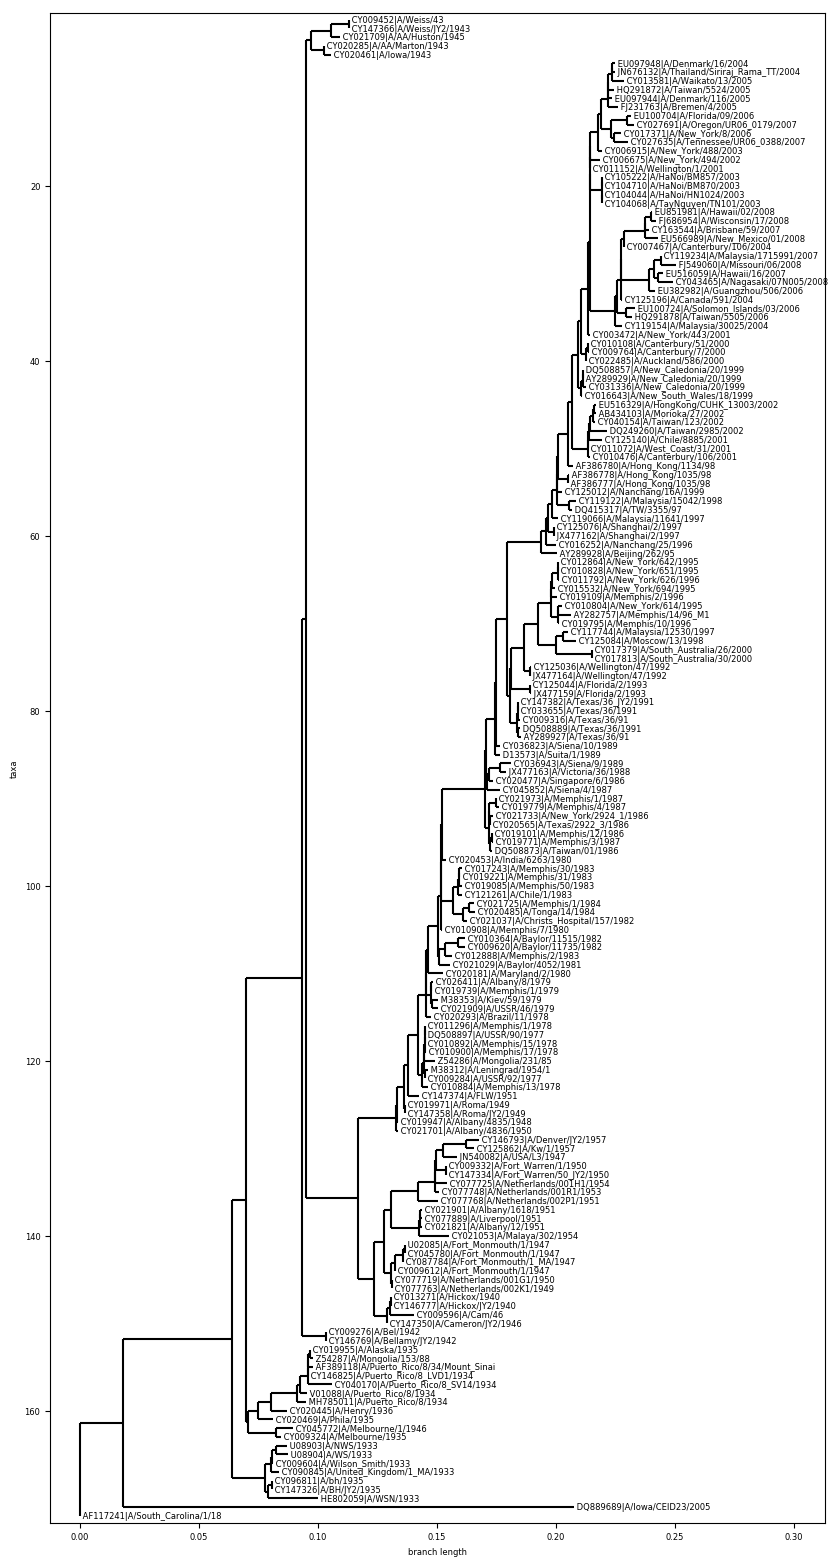

None


In [3]:
tree = Phylo.read("../results/tree_raw-5.nwk", "newick")
matplotlib.rc('font',size=6)
fig = plt.figure(figsize=(10,20), dpi=100)
axes=fig.add_subplot(1, 1, 1)
tree.ladderize(reverse=True)
tree.root_with_outgroup(outgroup_targets="AF117241|A/South_Carolina/1/18")
print(Phylo.draw(tree, axes=axes))

### Count tips

Same number of tips as sequences

In [5]:
tree.count_terminals()

172

In [8]:
seqCount = []
for record in SeqIO.parse("../results/filtered-5.fasta", "fasta"):
    seqCount.append(record.seq)

print(len(seqCount))

172


## Get time-resolved tree
### Augur refine

In [31]:
!augur refine \
  --tree ../results/tree_raw-5.nwk \
  --alignment ../results/aligned-5.fasta \
  --metadata ../data/metadata.tsv \
  --output-tree ../results/tree-5.nwk \
  --output-node-data ../results/branch_lengths-5.json \
  --timetree \
  --coalescent opt \
  --date-confidence \
  --date-inference joint 
#   --clock-filter-iqd 4


5.62	###TreeTime.run: INITIAL ROUND

29.10	###TreeTime.run: ITERATION 1 out of 2 iterations

60.76	###TreeTime.run: ITERATION 2 out of 2 iterations

195.86	###TreeTime.run: FINAL ROUND - confidence estimation via marginal reconstruction

Inferred a time resolved phylogeny using TreeTime:
	Sagulenko et al. TreeTime: Maximum-likelihood phylodynamic analysis
	Virus Evolution, vol 4, https://academic.oup.com/ve/article/4/1/vex042/4794731

updated tree written to ../results/tree-5.nwk
node attributes written to ../results/branch_lengths-5.json


### View

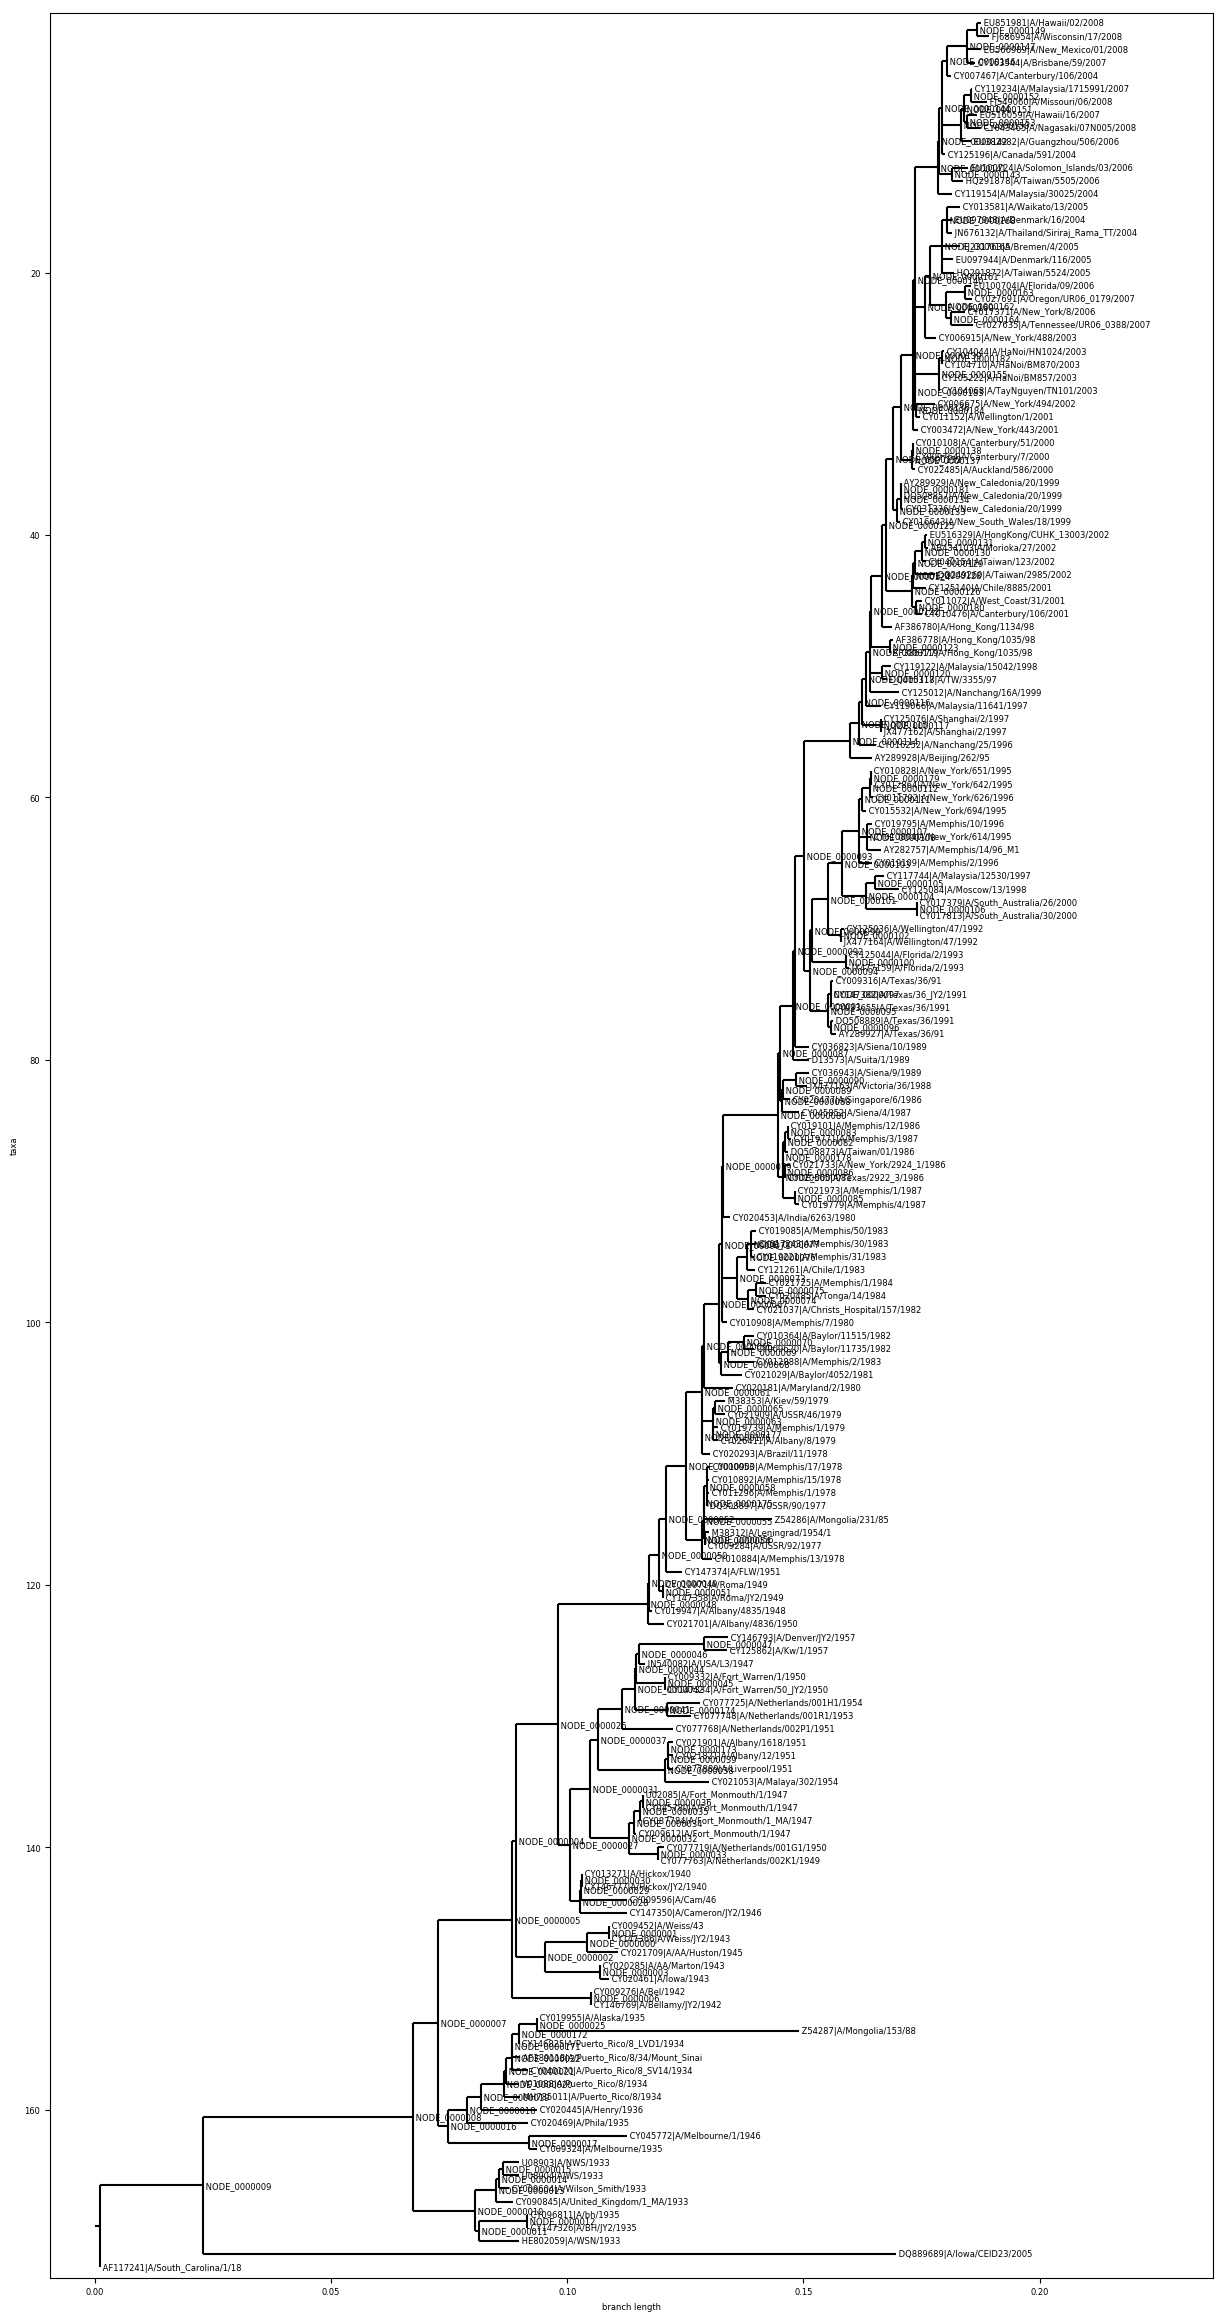

None


In [4]:
tree = Phylo.read("../results/tree-5.nwk", "newick")
matplotlib.rc('font',size=6)
fig = plt.figure(figsize=(15,30), dpi=100)
axes=fig.add_subplot(1,1,1)
tree.ladderize(reverse=True)
tree.root_with_outgroup(outgroup_targets="AF117241|A/South_Carolina/1/18")
print(Phylo.draw(tree, axes=axes))

### Trace tree

In [12]:
terminals = []
terminals.append(tree.get_terminals())


# print(terminal)

In [27]:
# for tip in tree, trace starting at tip and going to South_Carolina 1918 

traces = []
tips = []
for tip in tree.get_terminals():
    tips.append(tip)
    traces.append(tree.trace(start = tip, finish = "AF117241|A/South_Carolina/1/18"))
    
for trace in traces:
    for clade in trace:
        if clade.name == None:
            trace.remove(clade)

node_names = []
branch_lengths = []
index = 0
for trace in traces:
    prev_node = tips[index].name
    for node in trace:
        branch_lengths.append(node.branch_length)
        name = (prev_node + "-" + node.name )
        node_names.append(name)
        prev_node = node.name
    index += 1
    
stepwise_distances = list(zip(node_names, branch_lengths))

# df = pd.DataFrame(data = metadata, columns=['id', 'strain', 'year'])
dist_stepwise = pd.DataFrame(data = stepwise_distances, columns=['node_pairs', 'branch_lengths'])
dist_stepwise

# List with node_name and mutation from aa_muts.json for muts column?

,node_pairs,branch_lengths
0,EU851981|A/Hawaii/02/2008-NODE_0000149,0.002061
1,NODE_0000149-NODE_0000147,0.004120
2,NODE_0000147-NODE_0000146,0.001166
3,NODE_0000146-NODE_0000144,0.000643
4,NODE_0000144-NODE_0000142,0.000183
5,NODE_0000142-NODE_0000141,0.004967
6,NODE_0000141-NODE_0000140,0.000368
7,NODE_0000140-NODE_0000139,0.002501
8,NODE_0000139-NODE_0000136,0.001594
9,NODE_0000136-NODE_0000132,0.001631


In [21]:
traces

[[Clade(branch_length=0.00206051, name='NODE_0000149'),
  Clade(branch_length=0.00412018, name='NODE_0000147'),
  Clade(branch_length=0.00116597, name='NODE_0000146'),
  Clade(branch_length=0.00064304, name='NODE_0000144'),
  Clade(branch_length=0.00018273, name='NODE_0000142'),
  Clade(branch_length=0.00496668, name='NODE_0000141'),
  Clade(branch_length=0.00036817, name='NODE_0000140'),
  Clade(branch_length=0.00250127, name='NODE_0000139'),
  Clade(branch_length=0.00159419, name='NODE_0000136'),
  Clade(branch_length=0.00163143, name='NODE_0000132'),
  Clade(branch_length=0.00084295, name='NODE_0000125'),
  Clade(branch_length=0.00219673, name='NODE_0000124'),
  Clade(branch_length=0.0003682, name='NODE_0000122'),
  Clade(branch_length=0.00070973, name='NODE_0000119'),
  Clade(branch_length=0.00100767, name='NODE_0000118'),
  Clade(branch_length=0.00056536, name='NODE_0000116'),
  Clade(branch_length=0.00189037, name='NODE_0000115'),
  Clade(branch_length=0.00968283, name='NODE_0000

In [91]:
paths = []
for tip in tree.get_terminals():
    paths.append(tree.get_path(tip))

# Reverse the direction of the paths
index = 0
for path in paths:
    paths[index] = path[::-1]
    index += 1
    
# Distance between 
branch_lengths = []
node_names = []
for tip in paths:
    for parent in tip:
        branch_lengths.append(tree.distance(target1 = tip[0].name, target2 = parent.name))
        name = (tip[0].name + "-" + parent.name)
        node_names.append(name)

    


total_distances = list(zip(node_names, branch_lengths))

# df = pd.DataFrame(data = metadata, columns=['id', 'strain', 'year'])
dist_total = pd.DataFrame(data = distances, columns=['node_pairs', 'branch_lengths'])

dist_total


,node_pairs,branch_lengths
0,EU851981|A/Hawaii/02/2008-EU851981|A/Hawaii/02...,0.000000
1,EU851981|A/Hawaii/02/2008-NODE_0000149,0.000951
2,EU851981|A/Hawaii/02/2008-NODE_0000147,0.003012
3,EU851981|A/Hawaii/02/2008-NODE_0000146,0.007132
4,EU851981|A/Hawaii/02/2008-NODE_0000144,0.008298
5,EU851981|A/Hawaii/02/2008-NODE_0000142,0.008941
6,EU851981|A/Hawaii/02/2008-NODE_0000141,0.009124
7,EU851981|A/Hawaii/02/2008-NODE_0000140,0.014090
8,EU851981|A/Hawaii/02/2008-NODE_0000139,0.014458
9,EU851981|A/Hawaii/02/2008-NODE_0000136,0.016960


## Infer ancestral sequences

In [1]:
!augur ancestral \
  --tree ../results/tree-5.nwk \
  --alignment ../results/aligned-5.fasta \
  --output ../results/nt_muts-5.json \
  --inference joint


Inferred ancestral sequence states using TreeTime:
	Sagulenko et al. TreeTime: Maximum-likelihood phylodynamic analysis
	Virus Evolution, vol 4, https://academic.oup.com/ve/article/4/1/vex042/4794731

ancestral sequences written to ../results/nt_muts-5.json


## Identify amino acid mutations

In [123]:
from Bio.Seq import translate
import json

# Get names and sequences from nt_muts-5.json

with open("../results/nt_muts-5.json") as nt:
    nt_muts = json.load(nt)

aa_strains = []
nt_seqs = []
for strain in nt_muts['nodes'].keys():
    aa_strains.append(strain)
    
    # seqs as strings
    nt_seqs.append(nt_muts['nodes'][strain]['sequence'])
    
    # seqs as Seq object
#     nt_seqs.append(Seq(nt_muts['nodes'][strain]['sequence']))



# Remove problematic sequences
# del nt_seqs[65]
# del nt_seqs[120]
# del nt_seqs[122]
# del nt_seqs[151]
# del nt_seqs[205]


# aa_muts = []
counter = 0
for seq in nt_seqs:
    aa_muts.append(translate(seq, gap='-'))
    counter += 1


# Working with seqs as strings
translate(nt_seqs[5], gap = '-')

# Working with seqs as Seq object
# nt_seqs[65].translate(gap='-')
# nt_seqs[65]

# aa_strains[65]

# aa_seqs
# aa_strains
# nt_seqs



'MKANLLVLLSALAAADADTICIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDSHNGKLCRLKGIAPLQLGKCNIAGWLLGNPECDPLLPVRSWSYIVETPNSENGICYPGDFIDYEELREQLSSVSSFERFEIFPKESSWPNHNTN-GVTAACSHEGKSSFYRNLLWLTEKEGSYPKLKNSYVNKKGKEVLVLWGIHHPPNSKEQQNIYQNENAYVSVVTSNYNRRFTPEIAERPKVRDQAGRMNYYWTLLKPGDTIIFEANGNLIAPMYAFALSRGFGSGIITSNASMHECNTKCQTPLGAINSSLPYQNIHPVTIGECPKYVRSAKLRMVTGLRNTPSIQSRGLFGAIAGFIEGGWTGMIDGWYGYHHQNEQGSGYAADQKSTQNAINGITNKVNTVIEKMNIQFTAVGKEFNKLEKRMENLNKKVDDGFLDIWTYNAELLVLLENERTLDFHDSNVKNLYEKVKSQLKNNAKEIGNGCFEFYHKCDNECMESVRNGTYDYPKYSEESKLNREKVDGVKLESMGIYQILAIYSTVASSLVLLVSLGAISFWMCSNGSLQCRICI*'

In [122]:
counter

205

In [118]:
nt_seqs[122]

'ATGAAAGCAAAACTACTGATCCTGTTATGTGCACTTTCCGCTACAGATGCAGACACAATATGTATAGGCTACCATGCAAACAATTCAACCGACACTGTTGACACAGTACTCGAGAAGAATGTGACAGTGACACACTCTGTAAACCTACTCGAAGACAGCCACAATGGGAAATTATGCAGATTAAAAGGAAAAGCCCCACTACAATTGGGGAACTGTAACATTGCCGGATGGGTCTTAGGAAACCCAGAATGCGAATCATTGCTCTCCAATAGATCATGGTCCTACATTGCAGAAACACCAAACTCTGAGAATGGGACATGCTACCCAGGGGATTTCGCCGACTATGAGGAACTGAGGGAGCAATTGAGCTCAGTATCATCATTCGAGAGATTCGAAATATTCCCCAAGGAAAGATCATGGCCCA---ACCACACAACCAGAGGAGTGACGGCAGCATGCCCCCATGCGAGGAAAAGCAGTTTTTACAAAAATTTGGTCTGGCTGACGGAGGCAAATGGCTCATACCCAAATCTGAGCAGGTCCTATGTGAACAATCAAGAGAAAGAAGTCCTTGTGCTATGGGGAGTTCATCACCCGTCTAACATAGAGGAACAAAGGGCACTCTATCGGAAAGATAATGCTTATGTCTCTGTAGTGTCTTCAAATTATAACAGGAGATTCACCCCAGAAATAGCAAAAAGGCCCAAAGTAAGAGATCAATCAGGGAGAATGAACTATTACTGGACTTTGCTAGAACCCGGAGACACAATAATATTTGAGGCAACTGGAAATCTAATAGCACCATGGTATGCTTTCGCACTGAGTAGAGGCCCTGGATCAGGGATAATCACCTCAAACGCACCACTGGATGAATGTGACACAAAGTGTCAAACACCCCAGGGAGCTATAAACAGTAGTCTCCCTTTTCAGAATATACACCCTGTCACAATAGGAGAGTGCCCAAAATACGTCAGGAGTACGAAATTGAGGATGGTTACA

In [37]:
with open("../results/nt_muts-5.json") as nt:
    nt_muts = json.load(nt)


print(json.dumps(next(iter(nt_muts["nodes"]))), 
      json.dumps(next(iter(nt_muts["nodes"].values())), indent=4))

"AB434103|A/Morioka/27/2002" {
    "muts": [
        "A12G"
    ],
    "sequence": "ATGAAAGCAAAGCTACTGGTCCTGTTATGTACATTTACAGCTACATACGCAGACACAATATGTATAGGCTACCATGCCAACAACTCAACCGACACTGTTGACACAGTACTTGAGAAGAATGTGACAGTGACACACTCTGTCAACCTACTTGAGGACAGTCACAATGGAAAACTATGTCTACTAAAAGGAATAGCCCCACTACAATTGGGTAATTGCAGCGTTGCCGGATGGATCTTAGGAAACCCAGAATGCGAATTACTGATTTCCAAGGAATCATGGTCCTACATTGTAGAAACACCAAATCCCGAGAATGGAACATGTTACCCAGGGTATTTCGCCGACTATGAGGAACTGAGGGAGCAATTGAGTTCAGTATCTTCATTTGAGAGATTCGAAATATTCCCCAAAGGAAGCTCATGGCCCAACCACACCGTGACC---GGAGTATCAGCATCATGCTCCCATAATGGGAAAAGCAGTTTTTACAGAAATTTGCTATGGCTGACGGGGAAAAATGGTTTGTACCCAAACCTGAGCATGTCCTATGTAAACAACAAAGAAAAAGAAGTCCTTGTGCTATGGGGTGTTCATCACCCACCTAACATAGGGGACCAAAGGGCCCTCTACCATACAGAAAATGCTTATGTCTCTGTAGTGTCTTCACATTATAGCAGAAGATTCACCCCAGAAATAGCCAAAAGACCCAAAGTAAGAGATCAGGAAGGAAGAATCAACTACTACTGGACTCTGCTGGAACCCGGGGACACAATAATATTTGAGGCAAATGGAAATCTAATAGCGCCATGGTATGCTTTCGCACTGAGTAGAGGCTTTGGATCAGGAATCATCACCTCAAATGCACCAATGGGTGAATGTGATGCGAAGTGTCAAACACCTCAGGGAGCTATAAACAGTA

In [2]:
!augur translate \
  --tree ../results/tree-5.nwk \
  --ancestral-sequences ../results/nt_muts-5.json \
  --reference-sequence ../config/influenza-HA_outgroup.gb \
  --output ../results/aa_muts-5.json

Read in 1 features from reference sequence file
amino acid mutations written to ../results/aa_muts-5.json
